In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn

(i)knowledge-oblivious–the attacker shall have no knowledge of the target
model’s parameters/structures, nor the original training datasets, 

(ii) cleanlabel–the attacker shall not be able to control the labeling process, and

(iii)clean-test–test-time instances shall not be required to be modified using added
adversarial perturbations for attacking effectiveness

https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123720137.pdf

Make sure that you do not reuse the data for training, testing and the attack/defence. - prof

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 12, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 12, shuffle = True)

In [3]:
next(iter(trainloader))[0].size()

torch.Size([12, 1, 28, 28])

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1)
                ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
criterion = nn.NLLLoss()

In [6]:
train_losses, test_losses = [], []
epochs = 10


for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1).to(device)
    labels = labels.to(device)
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10.. Training loss: 0.643.. Test loss: 0.556.. Test Accuracy: 0.799
Epoch: 2/10.. Training loss: 0.535.. Test loss: 0.509.. Test Accuracy: 0.819
Epoch: 3/10.. Training loss: 0.512.. Test loss: 0.479.. Test Accuracy: 0.827
Epoch: 4/10.. Training loss: 0.502.. Test loss: 0.439.. Test Accuracy: 0.845
Epoch: 5/10.. Training loss: 0.487.. Test loss: 0.427.. Test Accuracy: 0.850
Epoch: 6/10.. Training loss: 0.479.. Test loss: 0.447.. Test Accuracy: 0.844
Epoch: 7/10.. Training loss: 0.466.. Test loss: 0.456.. Test Accuracy: 0.836
Epoch: 8/10.. Training loss: 0.466.. Test loss: 0.440.. Test Accuracy: 0.849
Epoch: 9/10.. Training loss: 0.456.. Test loss: 0.430.. Test Accuracy: 0.852
Epoch: 10/10.. Training loss: 0.456.. Test loss: 0.440.. Test Accuracy: 0.848


In [7]:
print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 10/10.. Training loss: 0.456.. Test loss: 0.440.. Test Accuracy: 0.848


In [8]:
print(device)

cuda:0


# Clustering (poisoned) training data to check for wrong labels

In [3]:
# clustering code

from clustering_ae import Clustering, utils

cae_PCA = Clustering(num_clusters=10,
        n_init = 5,
        epochs = 500,
        tol = 1e-5,
        initialization = "k-means++") 

cae_LDA = Clustering(num_clusters=10,
        n_init = 5,
        epochs = 500,
        tol = 1e-5,
        initialization = "k-means++") 

In [4]:
train_imgs, train_lbls = [], []
for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    train_imgs.extend(images.view(images.shape[0], -1).numpy())
    train_lbls.extend(labels.numpy())

In [5]:
test_imgs, test_lbls = [], []
for images, labels in testloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    test_imgs.extend(images.view(images.shape[0], -1).numpy())
    test_lbls.extend(labels.numpy())

In [6]:
import numpy as np
train_lbls = np.array(train_lbls)
test_lbls = np.array(test_lbls)

In [13]:
n_components = 10
encoder = 'PCA'
train_imgs_PCA, test_imgs_PCA = utils.encodePCA(train_imgs, test_imgs, n_components)
cae_PCA.train(train_imgs_PCA)
benchmark = cae_PCA.benchmark(f'Fashion mnist - {encoder} {n_components} components - train data', train_imgs_PCA, train_lbls)
print(benchmark[1])
benchmark_test = cae_PCA.benchmark(f'Fashion mnist - {encoder} {n_components} components - test data', test_imgs_PCA, test_lbls)
print(benchmark_test[1])

{'name': 'Fashion mnist - PCA 10 components - train data', 'duration': 0.18120574951171875, 'ari': 0.3463213451090269, 'nmi': 0.5088524454137134, 'dbi': 1.1289550595360593, 'silhouette': 0.2932904056463071, 'ch_score': 18763.969934565135, 'clustering_accuracy': 0.47081666666666666}
{'name': 'Fashion mnist - PCA 10 components - test data', 'duration': 0.06612753868103027, 'ari': 0.34831465484093077, 'nmi': 0.510692842693035, 'dbi': 1.1272363881052596, 'silhouette': 0.2928407729349374, 'ch_score': 3113.5563328696567, 'clustering_accuracy': 0.4823}


In [8]:
n_components = 5
encoder = 'LDA'
train_imgs_LDA, test_imgs_LDA = utils.encodeLDA(train_imgs, train_lbls, test_imgs, n_components)
cae_LDA.train(train_imgs_LDA)
benchmark = cae_LDA.benchmark(f'Fashion mnist - {encoder} {n_components} components - train data', train_imgs_LDA, train_lbls)
print(benchmark[1])
benchmark_test = cae_LDA.benchmark(f'Fashion mnist - {encoder} {n_components} components - test data', test_imgs_LDA, test_lbls)
print(benchmark_test[1])

{'name': 'Fashion mnist - LDA 5 components - train data', 'duration': 0.17103147506713867, 'ari': 0.5232691222327045, 'nmi': 0.6647031133260258, 'dbi': 0.9861927868386203, 'silhouette': 0.37836395214543467, 'ch_score': 58957.68201419389, 'clustering_accuracy': 0.6658166666666666}
{'name': 'Fashion mnist - LDA 5 components - test data', 'duration': 0.0593719482421875, 'ari': 0.5147060284226446, 'nmi': 0.6564028093329095, 'dbi': 0.9880056923462204, 'silhouette': 0.374379237724287, 'ch_score': 9574.117814520052, 'clustering_accuracy': 0.6594}


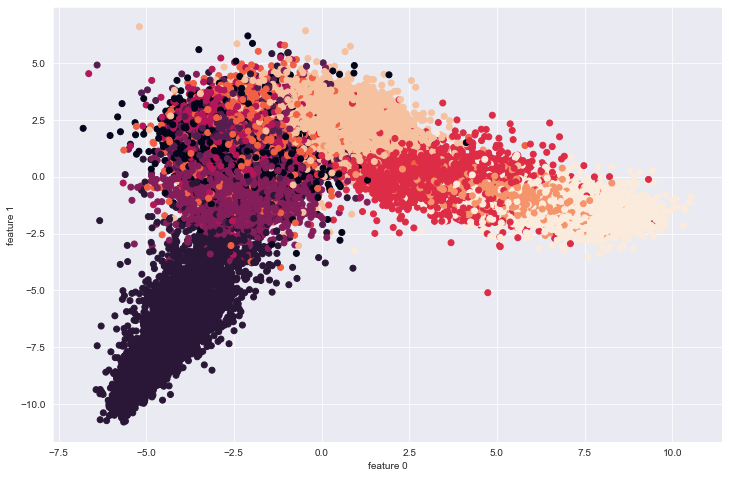

In [9]:
utils.plot(train_imgs_LDA, train_lbls, "2d")

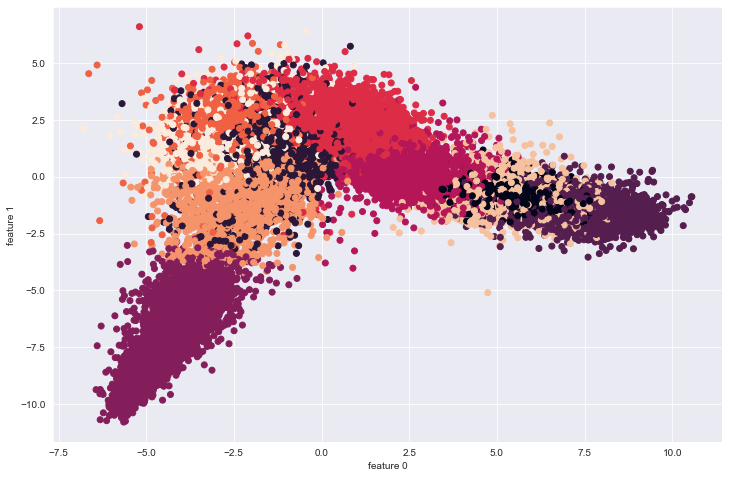

In [11]:
utils.plot(train_imgs_LDA, cae_LDA.model.labels_, "2d")